# A2C (Advantage Actor-Critic): Parallel Environments for Stable Learning

## 🎯 From Actor-Critic TD to A2C: Adding Parallelism

Welcome to **Advantage Actor-Critic (A2C)** - the practical solution that takes our Actor-Critic TD method and adds parallel environment collection for significantly more stable learning.

**The Core Innovation**: Instead of collecting N-step experience from a single environment, we collect N-step experience from **multiple parallel environments** simultaneously, then perform synchronous batch updates.

## 🔄 A3C → A2C: From Complexity to Simplicity

### The A3C Era (2016): Asynchronous Complexity

**A3C (Asynchronous Advantage Actor-Critic)** was a breakthrough algorithm that introduced parallel environment collection:
- **Multiple worker threads** collecting experience independently
- **Asynchronous updates** to shared network parameters
- **No replay buffer needed** - fresh on-policy data from parallel workers
- **Massive scalability** - could use dozens of CPU cores effectively

**A3C's Problems**:
- **Complex implementation**: Asynchronous updates, thread synchronization, shared memory
- **Difficult debugging**: Race conditions and non-deterministic behavior
- **Hyperparameter sensitivity**: Harder to tune due to asynchronous nature
- **Limited GPU utilization**: Asynchronous updates don't batch well for GPU training

### A2C (2017): Synchronous Simplification

**A2C** keeps A3C's core insight (parallel data collection) but simplifies the execution:
- **Synchronous updates**: All workers step in lockstep, then batch update
- **Simpler implementation**: No thread synchronization complexity
- **Deterministic training**: Reproducible results with proper seeding
- **GPU-friendly**: Natural batching for efficient neural network training
- **Easier debugging**: Predictable execution flow

**Why A2C Won**:
1. **Same performance**: A2C achieves similar results to A3C with much simpler code
2. **Better engineering**: Easier to implement, debug, and extend
3. **Industry adoption**: Became the standard for parallel on-policy RL
4. **GPU efficiency**: Better utilization of modern ML hardware

## 📊 A2C vs Actor-Critic TD: The Key Differences

| Aspect | Actor-Critic TD | A2C |
|--------|----------------|-----|
| **Environments** | Single | Multiple parallel |
| **Data Collection** | Sequential N-steps | Parallel N-steps from all envs |
| **Batch Size** | N transitions | N × num_envs transitions |
| **Update Frequency** | Every N steps | Every N steps (all envs) |
| **Gradient Variance** | High | Lower (averaged across envs) |
| **Implementation** | Simple | Moderate (vectorized envs) |
| **Sample Efficiency** | Standard | Same per env, but faster wall-clock |
| **Stability** | Moderate | Higher (batch averaging) |

## 🚀 A2C Algorithm Overview

**Algorithm: Advantage Actor-Critic (A2C)**

---
**Input:** 
- Unified Actor-Critic network with parameters $\theta$
- Number of parallel environments $E$
- N-step parameter $N$ 
- Learning rate $\alpha$
- Discount factor $\gamma$
- Maximum gradient norm $\text{max\_grad\_norm}$
- Number of episodes $M$
- $c_V$: Critic loss coefficient (typically 0.5)

**Output:** 
- Trained unified network parameters $\theta$

---
**Procedure:**
1. **Initialize** network parameters $\theta$ randomly
2. **Initialize** $E$ parallel environments
3. **For** iteration $i = 1, 2, ..., M$ **do:**
4. &nbsp;&nbsp;&nbsp;&nbsp;**For** $t = 1, 2, ..., N$ **do:** *(collect N-step experience)*
5. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**For each environment** $e = 1, 2, ..., E$ **do:**
6. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Sample action**: $a_t^{(e)} \sim \pi_\theta(\cdot|s_t^{(e)})$
7. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Execute**: $s_{t+1}^{(e)}, r_{t+1}^{(e)} \leftarrow \text{env}_e.\text{step}(a_t^{(e)})$
8. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Store**: $(s_t^{(e)}, a_t^{(e)}, r_{t+1}^{(e)}, \log \pi_\theta(a_t^{(e)}|s_t^{(e)}), V_\theta(s_t^{(e)}))$
9. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**End For**
10. &nbsp;&nbsp;&nbsp;&nbsp;**End For**
11. &nbsp;&nbsp;&nbsp;&nbsp;**Compute N-step advantages** for all environments using N-step TD
12. &nbsp;&nbsp;&nbsp;&nbsp;**Batch all transitions**: $B = \{(s,a,A,G)_{t,e} : t \in [1,N], e \in [1,E]\}$
13. &nbsp;&nbsp;&nbsp;&nbsp;**Actor loss**: $L^\pi(\theta) = -\mathbb{E}_{(s,a,A,G) \in B}[\log \pi_\theta(a|s) \cdot A]$
14. &nbsp;&nbsp;&nbsp;&nbsp;**Critic loss**: $L^V(\theta) = \mathbb{E}_{(s,a,A,G) \in B}[(V_\theta(s) - G)^2]$
15. &nbsp;&nbsp;&nbsp;&nbsp;**Total loss**: $L(\theta) = L^\pi(\theta) + c_v L^V(\theta)$
16. &nbsp;&nbsp;&nbsp;&nbsp;**Update parameters**: $\theta \leftarrow \theta - \alpha \nabla_\theta L(\theta)$
17. **End For**

---

## ⚡ Key Benefits of A2C

### ✅ Significant Advantages over Single-Environment Methods

1. **Reduced Gradient Variance**: Averaging gradients across multiple environments dramatically reduces variance
2. **Faster Wall-Clock Training**: Parallel data collection speeds up training significantly  
3. **More Stable Learning**: Batch updates from diverse environments prevent overfitting to single environment quirks
4. **Better Sample Diversity**: Each environment may be in different states, providing richer training signal
5. **Natural Regularization**: Averaging across environments acts as implicit regularization

### 🔄 Maintained Benefits

1. **N-Step Learning**: Still uses efficient N-step bootstrapping from Actor-Critic TD
2. **On-Policy**: Uses only fresh data from current policy
3. **No Replay Buffer**: Simpler than off-policy methods, no memory management complexity
4. **Action Space Flexibility**: Works with both discrete and continuous actions

### ⚖️ Trade-offs

1. **Implementation Complexity**: Requires vectorized environment handling
2. **Memory Usage**: Multiple environments increase memory requirements
3. **Hyperparameter Sensitivity**: Number of environments becomes additional hyperparameter
4. **Debugging Complexity**: Harder to debug issues across multiple environments

## 🛠️ Implementation Notes

For this implementation, we maintain the same hyperparameters as Actor-Critic TD (n_steps=5, same learning rates, etc.) to ensure fair comparison, with only the parallel environment collection being different.

We use Gymnasium's `SyncVectorEnv` for deterministic, reproducible parallel environment execution.

In [1]:
import numpy as np
import torch
import torch.optim as optim
from collections import deque
import time
from tqdm import tqdm


# Import our RL utilities including the ActorCriticNetwork
from rl_utils import (
    set_seeds,
    ActorCriticNetwork,
    create_env_with_wrappers,
    plot_training_results,
    plot_variance_analysis,
    make_vec_envs
)

# Create configuration
CONFIG = {
    "seed": 42,
    "episodes": 1000,
    "gamma": 0.99,
    "lr": 5e-4,
    "device": "cuda",
    "window_length": 50,
    "target_score": 200,  # LunarLander-v3 target score
    # Environment: LunarLander-v3 only
    "env_id": "LunarLander-v3",
    "env_kwargs": {
        "gravity": -10.0,
        "enable_wind": False,
        "wind_power": 15.0,
        "turbulence_power": 1.5,
    },
    # Video Recording Config
    "record_videos": True,
    "video_folder": "videos",
    "num_videos": 9,  # Number of videos to record during training
    "record_test_videos": True,
    # Neural Network Config
    "network": {
        "fc_out_features": [64, 64],  # Shared features
        "actor_features": [32],  # Actor-specific layers after shared
        "critic_features": [32],  # Critic-specific layers after shared
        "activation": "SiLU",
        "use_layer_norm": True,
        "dropout_rate": 0.0,
    },
    # Actor-Critic Specific Parameters
    "critic_loss_coeff": 0.5,  # Weight for critic loss in total loss
    # A2C-Specific Parameters
    "num_envs": 4,  # Number of parallel environments
    "n_steps": 5,  # N-step TD parameter (same as Actor-Critic TD)
    "max_grad_norm": 0.5,  # Maximum gradient norm for clipping
}

set_seeds(CONFIG["seed"])
print(f"🎲 Global random seeds set to {CONFIG['seed']} for reproducible results")
print(
    f"📝 Environment episodes will use seeds {CONFIG['seed']} + episode_number for varied but reproducible episodes"
)

🎲 Global random seeds set to 42 for reproducible results
📝 Environment episodes will use seeds 42 + episode_number for varied but reproducible episodes


In [2]:
class A2CAgent:
    """A2C agent with parallel environment collection."""

    def __init__(self, network, config):
        """
        Initialize A2C agent.

        Args:
            network: ActorCriticNetwork instance
            config: Configuration dictionary
        """
        self.network = network.to(config["device"])
        self.device = config["device"]
        self.gamma = config["gamma"]
        self.n_steps = config["n_steps"]
        self.num_envs = config["num_envs"]
        self.max_grad_norm = config["max_grad_norm"]
        self.window_size = config.get("window_length")

        # Actor-Critic specific parameters
        self.critic_loss_coeff = config.get("critic_loss_coeff")

        # Single optimizer for all network parameters
        self.optimizer = optim.Adam(
            self.network.parameters(),
            lr=config["lr"],
        )

        # Print detailed network information
        print(f"📊 A2C NETWORK DETAILS:")
        self.network.print_network_info()
        print(f"🌐 Number of Parallel Environments: {self.num_envs}")
        print(f"🎯 N-Steps: {self.n_steps}")
        print(f"🎓 Learning Rate: {config['lr']} (shared for actor & critic)")
        print(f"⚖️ Critic Loss Coefficient: {self.critic_loss_coeff}")
        print(f"✂️ Max Gradient Norm: {self.max_grad_norm}")

        # N-step buffer storage for all environments
        self.reset_buffers()

        # Variance and performance tracking - MODIFIED for vectorized environments
        self.gradient_norms = []
        self.vectorized_episode_scores = []  # Averaged episode scores across parallel environments
        self.score_variance_history = []

        # Update step tracking
        self.update_step = 0
        self.update_steps_history = []

        # Loss component tracking
        self.loss_history = {
            "actor_loss": [],
            "critic_loss": [],
            "total_loss": [],
        }

        # Advantage normalization fallback tracking
        self.advantage_norm_stats = {
            "total_actor_updates": 0,
            "fallback_normalizations": 0,
        }

        # Episode tracking for all environments - MODIFIED
        self.total_episodes = 0  # Total individual episodes completed across all environments
        self.vectorized_episodes = 0  # Number of vectorized episodes (averaged groups)
        self.env_episode_returns = [0.0] * self.num_envs
        self.completed_episode_scores = []  # Store all individual episode scores for averaging

    def reset_buffers(self):
        """Reset N-step buffers for all environments."""
        self.states = [[] for _ in range(self.num_envs)]
        self.actions = [[] for _ in range(self.num_envs)]
        self.rewards = [[] for _ in range(self.num_envs)]
        self.log_probs = [[] for _ in range(self.num_envs)]
        self.values = [[] for _ in range(self.num_envs)]

    def select_actions(self, states):
        """Select actions for all environments."""
        states = torch.as_tensor(states, dtype=torch.float32, device=self.device)
        
        # Get policy distribution and value estimates
        dist, values = self.network(states)
        actions = dist.sample()

        # Store log probabilities and value predictions
        if self.network.is_continuous:
            log_probs = dist.log_prob(actions).sum(-1)
            actions_to_env = [self.network.clip_action(actions[i]).flatten() for i in range(self.num_envs)]
        else:
            log_probs = dist.log_prob(actions)
            actions_to_env = actions.cpu().numpy()

        # Store in buffers for each environment
        for i in range(self.num_envs):
            self.states[i].append(states[i])
            self.actions[i].append(actions[i])
            self.log_probs[i].append(log_probs[i])
            self.values[i].append(values[i])

        return actions_to_env

    def store_rewards(self, rewards, dones):
        """Store rewards and handle episode completion."""
        for i in range(self.num_envs):
            self.rewards[i].append(rewards[i])
            self.env_episode_returns[i] += rewards[i]
            
            # If episode ended, store episode score
            if dones[i]:
                self.completed_episode_scores.append(self.env_episode_returns[i])
                self.env_episode_returns[i] = 0.0
                self.total_episodes += 1

    def should_update(self, step_count, dones):
        """Check if we should perform an update."""
        # Update every N steps OR when any environment terminates
        return step_count >= self.n_steps or any(dones) if dones is not None else False

    def update_policy(self, next_states=None, dones=None):
        """Update both actor and critic using N-step TD targets from all environments."""
        # Check if we have data to update
        if not any(len(env_rewards) > 0 for env_rewards in self.rewards):
            return {"actor_loss": 0.0, "critic_loss": 0.0, "total_loss": 0.0}, 0.0

        self.update_step += 1
        self.advantage_norm_stats["total_actor_updates"] += 1

        # Collect all transitions from all environments
        all_td_targets = []
        all_values = []
        all_log_probs = []

        for env_idx in range(self.num_envs):
            if len(self.rewards[env_idx]) == 0:
                continue

            # Calculate N-step TD targets for this environment
            td_targets = []
            
            # Get bootstrap value for the last state
            if dones is not None and dones[env_idx]:
                bootstrap_value = 0.0  # Terminal state has value 0
            elif next_states is not None:
                with torch.no_grad():
                    next_state_tensor = torch.as_tensor(next_states[env_idx], dtype=torch.float32, device=self.device)
                    _, bootstrap_value = self.network(next_state_tensor)
                    bootstrap_value = bootstrap_value.item()
            else:
                bootstrap_value = 0.0

            # Calculate N-step returns for this environment
            for i in range(len(self.rewards[env_idx])):
                td_target = 0.0
                discount = 1.0
                
                # Sum discounted rewards for available steps
                for j in range(i, len(self.rewards[env_idx])):
                    td_target += discount * self.rewards[env_idx][j]
                    discount *= self.gamma
                
                # Add bootstrapped value if not terminal
                if not (dones is not None and dones[env_idx] and i == len(self.rewards[env_idx]) - 1):
                    td_target += discount * bootstrap_value
                
                td_targets.append(td_target)

            # Collect data from this environment
            if len(td_targets) > 0:
                all_td_targets.extend(td_targets)
                all_values.extend(self.values[env_idx])
                all_log_probs.extend(self.log_probs[env_idx])

        if not all_td_targets:
            self.reset_buffers()
            return {"actor_loss": 0.0, "critic_loss": 0.0, "total_loss": 0.0}, 0.0

        # Convert to tensors
        td_targets = torch.tensor(all_td_targets, dtype=torch.float32, device=self.device)
        values_tensor = torch.stack(all_values)
        log_probs_tensor = torch.stack(all_log_probs)

        # Calculate advantages (no normalization of TD targets for critic!)
        advantages = td_targets - values_tensor.detach()

        # NOTE: Score variance tracking is now handled in finalize_vectorized_episode_data()
        # to ensure it's properly aligned with vectorized episodes

        # Robust advantage normalization: only check for NaN after normalization
        advantages_mean = advantages.mean()
        advantages_std = advantages.std()

        # Normalize advantages, fallback to centering if NaN occurs
        advantages_normalized = (advantages - advantages_mean) / (advantages_std + 1e-8)
        if torch.isnan(advantages_normalized).any():
            self.advantage_norm_stats["fallback_normalizations"] += 1
            advantages_normalized = advantages - advantages_mean

        actor_loss = -(log_probs_tensor * advantages_normalized).mean()

        # Critic loss (no normalization of targets!)
        critic_loss = torch.nn.functional.mse_loss(values_tensor, td_targets)

        # Total loss
        total_loss = actor_loss + self.critic_loss_coeff * critic_loss

        # Update network with gradient clipping
        self.optimizer.zero_grad()
        total_loss.backward()

        # Record gradient norm BEFORE clipping
        total_grad_norm = 0.0
        for param in self.network.parameters():
            if param.grad is not None:
                param_norm = param.grad.data.norm(2)
                total_grad_norm += param_norm.item() ** 2
        total_grad_norm = total_grad_norm**0.5
        self.gradient_norms.append(total_grad_norm)

        # Apply gradient clipping
        torch.nn.utils.clip_grad_norm_(self.network.parameters(), self.max_grad_norm)

        self.optimizer.step()

        # Log losses
        actor_loss_value = actor_loss.item()
        critic_loss_value = critic_loss.item()
        total_loss_value = total_loss.item()
        self.loss_history["actor_loss"].append(actor_loss_value)
        self.loss_history["critic_loss"].append(critic_loss_value)
        self.loss_history["total_loss"].append(total_loss_value)
        self.update_steps_history.append(self.update_step)

        # Reset buffers for next collection
        self.reset_buffers()

        return {
            "actor_loss": actor_loss_value,
            "critic_loss": critic_loss_value,
            "total_loss": total_loss_value,
        }, total_grad_norm

    def finalize_vectorized_episode_data(self):
        """
        Aggregate and finalize vectorized episode data for plotting.
        Called when we have enough completed episodes for averaging.
        """
        if len(self.completed_episode_scores) >= self.num_envs:
            # Take the last num_envs completed episodes and average them
            recent_episodes = self.completed_episode_scores[-self.num_envs:]
            averaged_score = np.mean(recent_episodes)
            self.vectorized_episode_scores.append(averaged_score)
            self.vectorized_episodes += 1
            
            # Remove the episodes we just processed
            self.completed_episode_scores = self.completed_episode_scores[:-self.num_envs]
            
            # Track score variance ONLY when we have enough vectorized episodes
            if len(self.vectorized_episode_scores) >= self.window_size:
                recent_scores = self.vectorized_episode_scores[-self.window_size:]
                score_variance = np.var(recent_scores)
                self.score_variance_history.append(score_variance)
            else:
                # For the first few vectorized episodes, we don't have enough data for variance
                # but we still want to track something for consistency
                self.score_variance_history.append(0.0)

    def get_variance_stats(self):
        """Get variance statistics for analysis."""
        if len(self.vectorized_episode_scores) < 2:
            return {
                "gradient_norm_mean": 0.0,
                "gradient_norm_std": 0.0,
                "score_mean": 0.0,
                "score_std": 0.0,
                "recent_score_variance": 0.0,
            }

        return {
            "gradient_norm_mean": np.mean(self.gradient_norms),
            "gradient_norm_std": np.std(self.gradient_norms),
            "score_mean": np.mean(self.vectorized_episode_scores),
            "score_std": np.std(self.vectorized_episode_scores),
            "recent_score_variance": (
                self.score_variance_history[-1]
                if self.score_variance_history
                else 0.0
            ),
        }

    def get_advantage_normalization_stats(self):
        """Get fallback normalization statistics."""
        stats = self.advantage_norm_stats.copy()
        
        # Calculate fallback rate
        if stats["total_actor_updates"] > 0:
            fallback_rate = stats["fallback_normalizations"] / stats["total_actor_updates"]
            stats["fallback_rate_percent"] = fallback_rate * 100.0
        else:
            stats["fallback_rate_percent"] = 0.0
        
        return stats

In [3]:
def train_a2c(is_continuous, config):
    """Main training loop for the A2C agent."""
    action_type = "Continuous" if is_continuous else "Discrete"
    print(f"\n{'='*70}")
    print(
        f"A2C ({action_type.upper()}) - Parallel {config['num_envs']}-Environment Training"
    )
    print(
        f"Target vectorized episodes: {config['episodes']} (averaged across {config['num_envs']} parallel envs)"
    )
    print(f"{'='*70}")

    # Calculate video recording interval BEFORE creating environments
    video_record_interval = max(1, config['episodes'] // config['num_videos'])
    print(
        f"📹 Recording {config['num_videos']} videos every {video_record_interval} vectorized episodes"
    )

    # Update config with video_record_interval
    config_for_envs = config.copy()
    config_for_envs["video_record_interval"] = video_record_interval

    # Create Vectorized Environment
    vec_env, config_with_videos = make_vec_envs(
        config_for_envs,
        is_continuous,
        record_videos=True,
        video_prefix=f"a2c_{action_type.lower()}",
        cleanup_existing=True,
    )

    # Get observation dimension from a single environment
    dummy_obs, _ = vec_env.envs[0].reset()
    observation_dim = len(dummy_obs)

    # Create Actor-Critic Network and Agent
    print(f"\n🏗️ CREATING {action_type.upper()} ACTOR-CRITIC NETWORK:")
    network = ActorCriticNetwork(
        observation_dim=observation_dim,
        action_space=vec_env.single_action_space,
        is_continuous=is_continuous,
        network_config=config["network"],
    )

    print(f"\n🤖 INITIALIZING {action_type.upper()} A2C AGENT:")
    agent = A2CAgent(network, config)

    # Training Loop
    scores = []  # These will be averaged scores across parallel environments
    scores_window = deque(maxlen=config["window_length"])
    start_time = time.time()

    print(f"\n🚀 STARTING {action_type.upper()} TRAINING...")

    # Initialize parallel environments
    states, _ = vec_env.reset(seed=config["seed"])
    step_count = 0
    vectorized_episode_count = 0  # Track vectorized episodes (averaged across parallel environments)

    # Use tqdm for progress tracking
    pbar = tqdm(total=config["episodes"], desc="Training", unit="vec-episode")

    # Continue until we reach target vectorized episodes
    while vectorized_episode_count < config["episodes"]:
        # Collect N-step experience
        while step_count < config["n_steps"] and vectorized_episode_count < config["episodes"]:
            actions = agent.select_actions(states)

            next_states, rewards, terminateds, truncateds, infos = vec_env.step(actions)
            dones = np.logical_or(terminateds, truncateds)

            agent.store_rewards(rewards, dones)

            # Handle episode completion
            episodes_completed_this_step = sum(dones)
            if episodes_completed_this_step > 0:
                # Check if we can create an averaged vectorized episode
                agent.finalize_vectorized_episode_data()
                
                # Update vectorized episode count based on completed averaged episodes
                if len(agent.vectorized_episode_scores) > vectorized_episode_count:
                    new_vectorized_episodes = len(agent.vectorized_episode_scores) - vectorized_episode_count
                    vectorized_episode_count += new_vectorized_episodes
                    
                    # Update scores tracking
                    for i in range(new_vectorized_episodes):
                        episode_idx = vectorized_episode_count - new_vectorized_episodes + i
                        if episode_idx < len(agent.vectorized_episode_scores):
                            score = agent.vectorized_episode_scores[episode_idx]
                            scores.append(score)
                            scores_window.append(score)

                    # Handle video display for vectorized episode intervals
                    if vectorized_episode_count % video_record_interval == 0 and config["record_videos"]:
                        from rl_utils.environment import display_latest_video
                        pbar.write(f"\nVideo recorded at vectorized episode {vectorized_episode_count}")
                        display_latest_video(
                            config_with_videos["video_folder"],
                            f"a2c_{action_type.lower()}",
                            vectorized_episode_count,
                        )

            states = next_states
            step_count += 1

        # Update policy when we have enough steps OR any environment terminated
        if agent.should_update(step_count, dones) and vectorized_episode_count < config["episodes"]:
            loss_dict, grad_norm = agent.update_policy(next_states, dones)
            step_count = 0  # Reset step count after update

            # Update progress bar
            if scores:
                avg_score_window = (
                    np.mean(scores_window) if len(scores_window) > 0 else 0.0
                )
                actor_loss = loss_dict.get("actor_loss", 0.0)
                critic_loss = loss_dict.get("critic_loss", 0.0)
                total_loss = loss_dict.get("total_loss", 0.0)

                # Get advantage normalization fallback rate
                adv_stats = agent.get_advantage_normalization_stats()
                failure_rate = adv_stats.get("fallback_rate_percent", 0.0)

                pbar.set_description(
                    f"VecEp {vectorized_episode_count:4d} | "
                    f"Score: {scores[-1] if scores else 0.0:6.1f} | "
                    f"AvgScore({config['window_length']}): {avg_score_window:6.1f} | "
                    f"Updates: {agent.update_step:4d} | "
                    f"ActorLoss: {actor_loss:7.4f} | "
                    f"CriticLoss: {critic_loss:7.4f} | "
                    f"GradNorm: {grad_norm:6.4f} | "
                    f"AdvFail: {failure_rate:4.1f}%"
                )
                pbar.n = min(vectorized_episode_count, config["episodes"])
                pbar.refresh()

    pbar.close()
    vec_env.close()

    elapsed_time = time.time() - start_time
    final_window_size = min(config["window_length"], len(scores))
    final_performance = (
        np.mean(scores[-final_window_size:]) if final_window_size > 0 else 0.0
    )

    # Print results
    adv_stats = agent.get_advantage_normalization_stats()
    print(f"\n{action_type} training completed in {elapsed_time:.1f} seconds!")
    print(f"Vectorized episodes completed: {vectorized_episode_count} (averaged across {config['num_envs']} parallel envs)")
    print(f"Total individual episodes: {agent.total_episodes}")
    print(
        f"Final performance: {final_performance:.2f} (last {final_window_size} vectorized episodes)"
    )
    print(f"Total updates performed: {agent.update_step}")
    print(f"Updates per vectorized episode: {agent.update_step / max(1, vectorized_episode_count):.1f}")
    print(f"Updates per individual episode: {agent.update_step / max(1, agent.total_episodes):.1f}")

    return scores, agent.loss_history, agent

In [4]:
# --- DISCRETE ACTION SPACE: A2C ---
print("Starting A2C training with DISCRETE actions...")

discrete_a2c_scores, discrete_a2c_losses, discrete_a2c_agent = train_a2c(
    is_continuous=False, 
    config=CONFIG
)


📹 Displaying 9 training videos (episodes: [110, 221, 332, 443, 554, 665, 776, 887, 998]):


VecEp  999 | Score:   58.3 | AvgScore(50):   84.1 | Updates: 71089 | ActorLoss:  0.1130 | CriticLoss: 497.8286 | GradNorm: 1141.5708 | AdvFail:  0.0%: 100%|█████████▉| 999/1000 [58:08<00:03,  3.49s/vec-episode]

📹 9 training videos available in videos/a2c_discrete_discrete


VecEp  999 | Score:   58.3 | AvgScore(50):   84.1 | Updates: 71116 | ActorLoss: -0.1937 | CriticLoss: 45.7970 | GradNorm: 659.9960 | AdvFail:  0.0%: 100%|█████████▉| 999/1000 [58:09<00:03,  3.49s/vec-episode]   


Discrete training completed in 3489.6 seconds!
Vectorized episodes completed: 1000 (averaged across 4 parallel envs)
Total individual episodes: 4000
Final performance: 85.49 (last 50 vectorized episodes)
Total updates performed: 71116
Updates per vectorized episode: 71.1
Updates per individual episode: 17.8


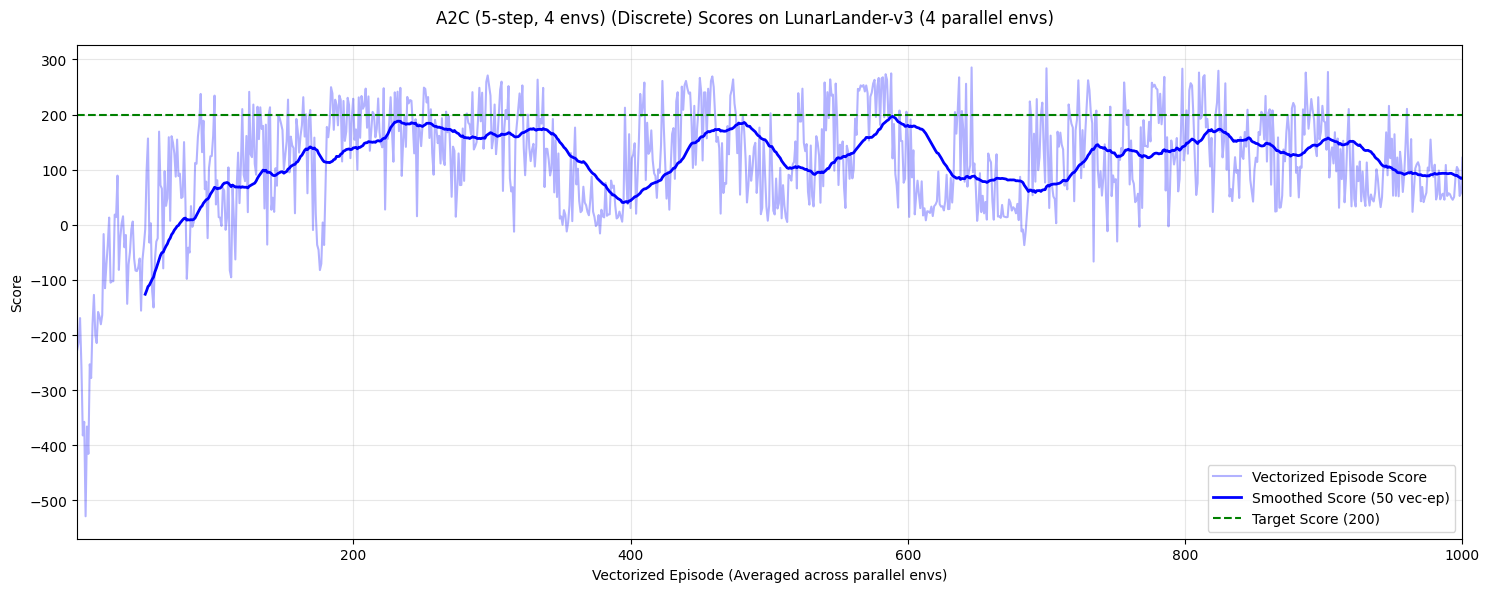

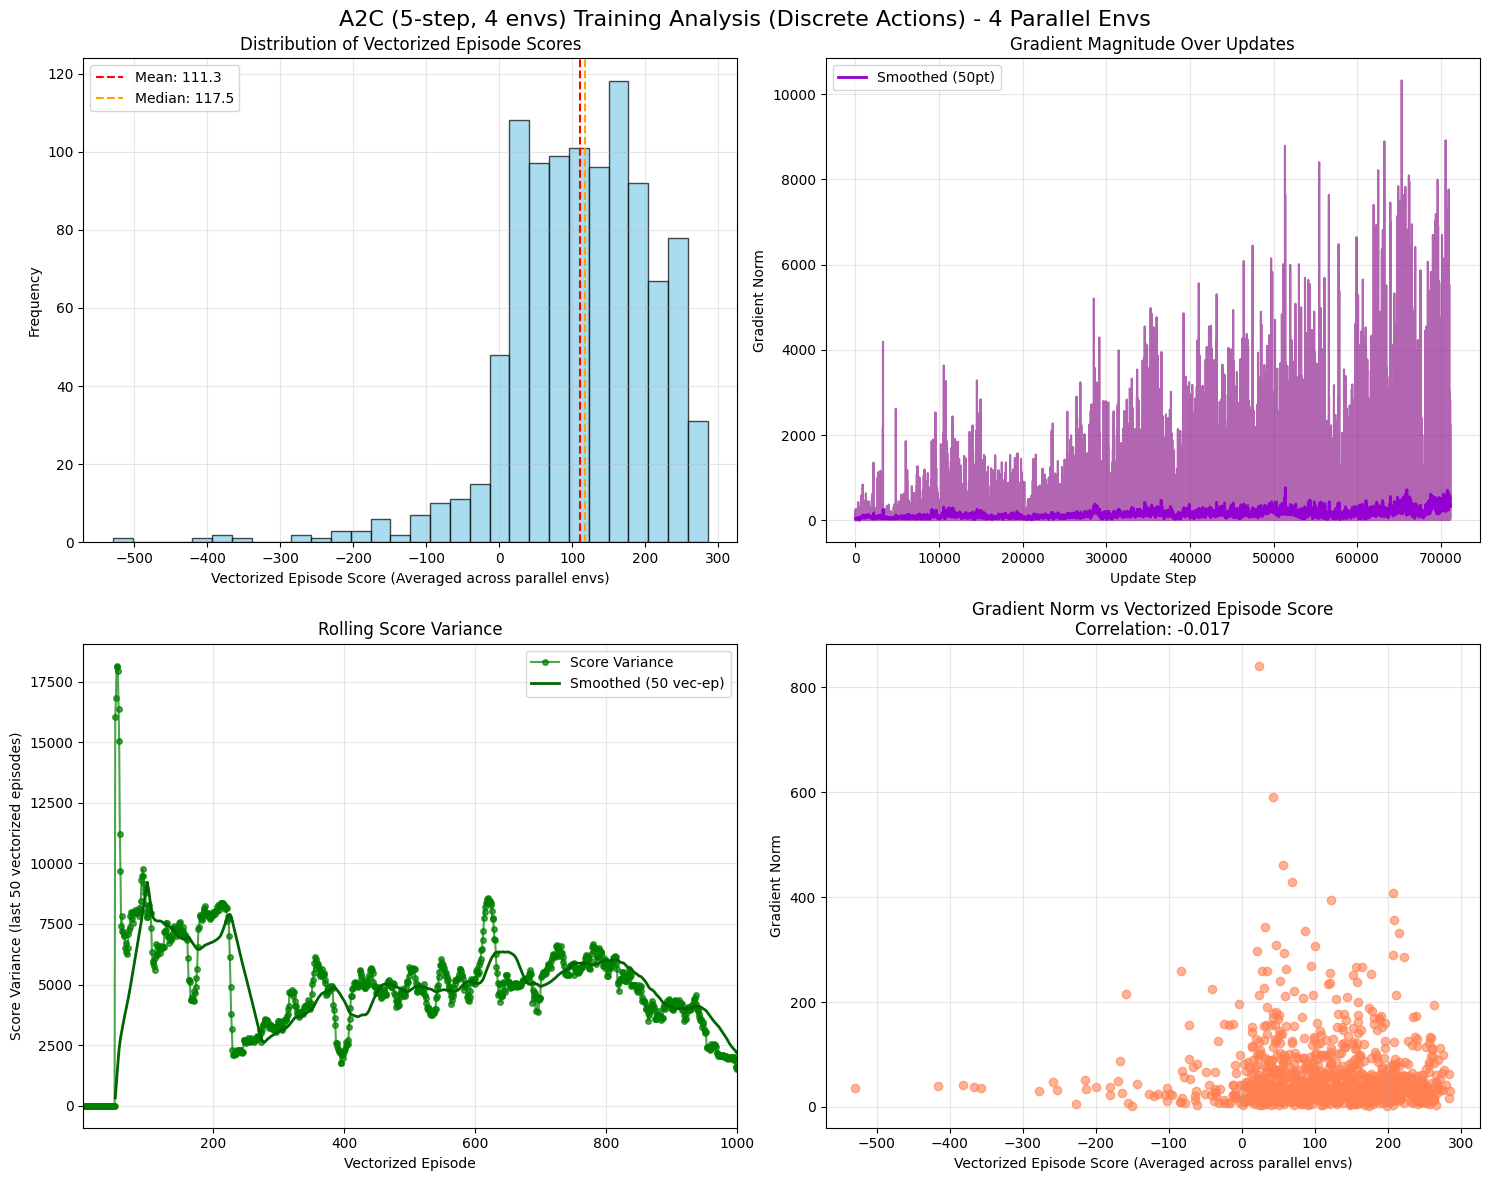


--- A2C (5-step, 4 envs) Training Statistics (Discrete) ---
Vectorized Episode Scores: μ=111.28, σ=99.37
Recent Score Variance: 1505.13
Gradient Norms: μ=159.0802, σ=438.4220
Total Update Steps: 71116
Total Individual Episodes: 4000 (across 4 parallel envs)
Vectorized Episodes Completed: 1000
Score Variance History Length: 1000

🔍 DISCRETE A2C ADVANTAGE NORMALIZATION ANALYSIS:
Fallback normalization rate: 0.00% (0 of 71116)

✅ DISCRETE A2C TRAINING COMPLETED!
Final average score (last 50 vectorized episodes): 85.49
Network parameters: 9,445
Parallel environments: 4


In [5]:
# Plot results for discrete A2C using vectorized plotting
from rl_utils import plot_vectorized_training_results, plot_vectorized_variance_analysis

plot_vectorized_training_results(
    discrete_a2c_scores, 
    discrete_a2c_agent.loss_history, 
    CONFIG, 
    "Discrete", 
    algorithm_name=f"A2C ({CONFIG['n_steps']}-step, {CONFIG['num_envs']} envs)"
)

# Show variance analysis
plot_vectorized_variance_analysis(
    discrete_a2c_agent, 
    discrete_a2c_scores, 
    "Discrete", 
    CONFIG, 
    algorithm_name=f"A2C ({CONFIG['n_steps']}-step, {CONFIG['num_envs']} envs)"
)

# Show advantage normalization statistics
adv_stats = discrete_a2c_agent.get_advantage_normalization_stats()
print(f"\n🔍 DISCRETE A2C ADVANTAGE NORMALIZATION ANALYSIS:")
print(f"Fallback normalization rate: {adv_stats['fallback_rate_percent']:.2f}% ({adv_stats['fallback_normalizations']} of {adv_stats['total_actor_updates']})")

# Training completion message
final_window_size = min(CONFIG["window_length"], len(discrete_a2c_scores))
final_avg = np.mean(discrete_a2c_scores[-final_window_size:]) if final_window_size > 0 else 0.0
print(f"\n✅ DISCRETE A2C TRAINING COMPLETED!")
print(f"Final average score (last {final_window_size} vectorized episodes): {final_avg:.2f}")
print(f"Network parameters: {discrete_a2c_agent.network.get_param_count():,}")
print(f"Parallel environments: {CONFIG['num_envs']}")

In [ ]:
# --- CONTINUOUS ACTION SPACE: A2C ---
print("Starting A2C training with CONTINUOUS actions...")

continuous_a2c_scores, continuous_a2c_losses, continuous_a2c_agent = train_a2c(
    is_continuous=True, 
    config=CONFIG
)

/home/tk/.virtualenvs/dev-python3.11/lib/python3.11/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /home/tk/repos/on-policy-rl/videos/a2c_continuous_continuous folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Starting A2C training with CONTINUOUS actions...

A2C (CONTINUOUS) - Parallel 4-Environment Training
Target vectorized episodes: 1000 (averaged across 4 parallel envs)
📹 Recording 9 videos every 111 vectorized episodes
🗑️ Cleaning up entire video folder: videos/a2c_continuous_continuous
   Video folder cleaned and recreated.

🏗️ CREATING CONTINUOUS ACTOR-CRITIC NETWORK:

🤖 INITIALIZING CONTINUOUS A2C AGENT:
📊 A2C NETWORK DETAILS:
ActorCriticNetwork (Continuous) initialized with 9,381 trainable parameters.
  Shared features:     4,992 parameters
  Actor branch:        2,212 parameters
    - Actor FC layers: 2,144 parameters
    - Actor head:      68 parameters
  Critic branch:       2,177 parameters
    - Critic FC layers:2,144 parameters
    - Critic head:     33 parameters
Action bounds: Low=[-1. -1.], High=[1. 1.]
🌐 Number of Parallel Environments: 4
🎯 N-Steps: 5
🎓 Learning Rate: 0.0005 (shared for actor & critic)
⚖️ Critic Loss Coefficient: 0.5
✂️ Max Gradient Norm: 0.5

🚀 STARTING 

VecEp   93 | Score:   67.4 | AvgScore(50):  -34.0 | Updates: 10838 | ActorLoss: -0.2998 | CriticLoss:  4.8391 | GradNorm: 44.9830 | AdvFail:  0.0%:   9%|▉         | 93/1000 [10:21<1:40:59,  6.68s/vec-episode]    

In [ ]:
# Plot results for continuous A2C using vectorized plotting
plot_vectorized_training_results(
    continuous_a2c_scores, 
    continuous_a2c_agent.loss_history, 
    CONFIG, 
    "Continuous", 
    algorithm_name=f"A2C ({CONFIG['n_steps']}-step, {CONFIG['num_envs']} envs)"
)

# Show variance analysis
plot_vectorized_variance_analysis(
    continuous_a2c_agent, 
    continuous_a2c_scores, 
    "Continuous", 
    CONFIG, 
    algorithm_name=f"A2C ({CONFIG['n_steps']}-step, {CONFIG['num_envs']} envs)"
)

# Show advantage normalization statistics
adv_stats = continuous_a2c_agent.get_advantage_normalization_stats()
print(f"\n🔍 CONTINUOUS A2C ADVANTAGE NORMALIZATION ANALYSIS:")
print(f"Fallback normalization rate: {adv_stats['fallback_rate_percent']:.2f}% ({adv_stats['fallback_normalizations']} of {adv_stats['total_actor_updates']})")

# Training completion message
final_window_size = min(CONFIG["window_length"], len(continuous_a2c_scores))
final_avg = np.mean(continuous_a2c_scores[-final_window_size:]) if final_window_size > 0 else 0.0
print(f"\n✅ CONTINUOUS A2C TRAINING COMPLETED!")
print(f"Final average score (last {final_window_size} vectorized episodes): {final_avg:.2f}")
print(f"Network parameters: {continuous_a2c_agent.network.get_param_count():,}")
print(f"Parallel environments: {CONFIG['num_envs']}")

In [ ]:
# --- COMPREHENSIVE ANALYSIS: A2C Performance and Parallel Environment Benefits ---
import matplotlib.pyplot as plt
from rl_utils.visualization import get_moving_average

print(f"\n{'='*80}")
print(f"COMPREHENSIVE ANALYSIS: A2C Performance and Parallel Environment Benefits")
print(f"{'='*80}")

# Collect experiment results
experiments = [
    ("Discrete A2C", discrete_a2c_scores, discrete_a2c_agent),
    ("Continuous A2C", continuous_a2c_scores, continuous_a2c_agent),
]

print(f"\n📊 FINAL PERFORMANCE COMPARISON (last {CONFIG['window_length']} vectorized episodes):")
print(f"{'Method':<20} {'Final Score':<12} {'Score Std':<10} {'Updates':<8} {'Up/VecEp':<8} {'AdvFail%':<10} {'Parameters':<12}")
print("-" * 85)

for name, scores, agent in experiments:
    final_window_size = min(CONFIG["window_length"], len(scores))
    final_score = np.mean(scores[-final_window_size:]) if final_window_size > 0 else 0.0
    
    stats = agent.get_variance_stats()
    total_updates = getattr(agent, 'update_step', 0)
    updates_per_vectorized_episode = total_updates / max(1, agent.vectorized_episodes) if hasattr(agent, 'vectorized_episodes') else 0.0
    adv_stats = agent.get_advantage_normalization_stats()
    failure_rate = adv_stats.get("fallback_rate_percent", 0.0)
    param_count = agent.network.get_param_count()
    
    print(f"{name:<20} {final_score:<12.1f} {stats['score_std']:<10.1f} {total_updates:<8} {updates_per_vectorized_episode:<8.1f} {failure_rate:<10.1f} {param_count:<12,}")

print(f"\n📈 A2C-SPECIFIC ANALYSIS:")
for name, scores, agent in experiments:
    stats = agent.get_variance_stats()
    recent_score_var = stats.get('recent_score_variance', 0.0)
    adv_stats = agent.get_advantage_normalization_stats()
    
    print(f"{name}:")
    print(f"  Score variance (last {CONFIG['window_length']} vectorized episodes): {recent_score_var:.1f}")
    print(f"  Advantage norm fallbacks: {adv_stats['fallback_normalizations']} of {adv_stats['total_actor_updates']} ({adv_stats['fallback_rate_percent']:.1f}%)")
    print(f"  Parallel environments: {CONFIG['num_envs']}")
    print(f"  N-step parameter: {CONFIG['n_steps']} steps")

# Create A2C-specific analysis plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle(f'A2C ({CONFIG["n_steps"]}-Step, {CONFIG["num_envs"]} Envs): Performance Analysis', fontsize=16)

colors = ['blue', 'red']
smoothing_window = CONFIG["window_length"]

# 1. Performance comparison
for i, (name, scores, agent) in enumerate(experiments):
    if len(scores) >= smoothing_window:
        smoothed, offset = get_moving_average(scores, window=smoothing_window)
        episodes = range(offset + 1, offset + 1 + len(smoothed))
        ax1.plot(episodes, smoothed, label=name, color=colors[i], linewidth=2)

ax1.axhline(y=CONFIG["target_score"], color='g', linestyle='--', label=f'Target ({CONFIG["target_score"]})', alpha=0.7)
ax1.set_xlabel('Vectorized Episode')
ax1.set_ylabel(f'Score ({smoothing_window}-episode avg)')
ax1.set_title('Performance Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Update frequency (gradient norms over update steps, not episodes)
for i, (name, scores, agent) in enumerate(experiments):
    if len(agent.gradient_norms) >= smoothing_window:
        smoothed, offset = get_moving_average(agent.gradient_norms, window=smoothing_window)
        update_steps = range(offset + 1, offset + 1 + len(smoothed))
        ax2.plot(update_steps, smoothed, label=name, color=colors[i], linewidth=2)

ax2.set_xlabel('Update Step')
ax2.set_ylabel(f'Gradient Norm ({smoothing_window}-step avg)')
ax2.set_title('Gradient Stability Over Updates')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Loss components over update steps
for i, (name, scores, agent) in enumerate(experiments):
    if len(agent.loss_history["total_loss"]) >= smoothing_window:
        # Plot total loss
        smoothed_total, offset = get_moving_average(agent.loss_history["total_loss"], window=smoothing_window)
        update_steps = range(offset + 1, offset + 1 + len(smoothed_total))
        ax3.plot(update_steps, smoothed_total, label=f'{name} Total', color=colors[i], linewidth=2)
        
        # Plot actor and critic losses with transparency
        if len(agent.loss_history["actor_loss"]) >= smoothing_window:
            smoothed_actor, _ = get_moving_average(agent.loss_history["actor_loss"], window=smoothing_window)
            ax3.plot(update_steps, smoothed_actor, label=f'{name} Actor', color=colors[i], alpha=0.6, linestyle='--')
        
        if len(agent.loss_history["critic_loss"]) >= smoothing_window:
            smoothed_critic, _ = get_moving_average(agent.loss_history["critic_loss"], window=smoothing_window)
            ax3.plot(update_steps, smoothed_critic, label=f'{name} Critic', color=colors[i], alpha=0.6, linestyle=':')

ax3.set_xlabel('Update Step')
ax3.set_ylabel(f'Loss Value ({smoothing_window}-step avg)')
ax3.set_title('Loss Components Over Updates')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Score variance over time - FIXED to use vectorized episodes
for i, (name, scores, agent) in enumerate(experiments):
    if len(agent.score_variance_history) > 0:
        # Score variance is calculated per vectorized episode, starting from when we have enough data
        variance_start_episode = CONFIG["window_length"]  # Start from when we have window_length vectorized episodes
        variance_episodes = range(variance_start_episode, variance_start_episode + len(agent.score_variance_history))
        ax4.plot(variance_episodes, agent.score_variance_history, label=name, color=colors[i], alpha=0.7)

ax4.set_xlabel('Vectorized Episode')
ax4.set_ylabel(f'Score Variance (last {CONFIG["window_length"]} vectorized episodes)')
ax4.set_title('Score Variance Over Time')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()